### Recurrent Neurons and Layers

1. Let’s look at the simplest possible RNN, composed of one neuron receiving
inputs, producing an output, and sending that output back to itself, as shown
in Figure 15-1 (left).

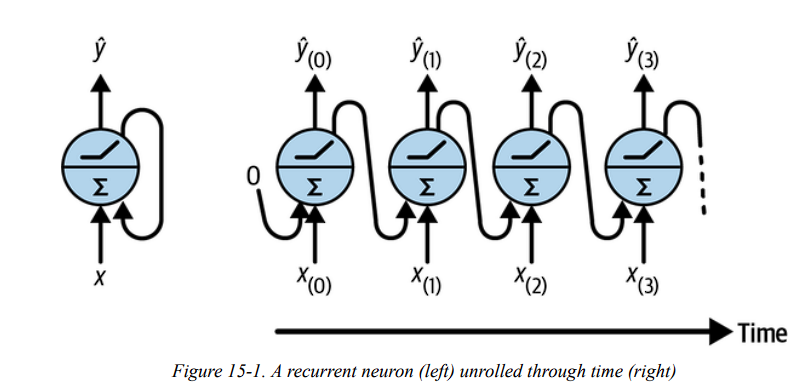

2. This is called unrolling the network
through time (it’s the same recurrent neuron represented once per time
step):<br>
At each time step t (also called a frame), this recurrent
neuron receives the inputs x_(t) as well as its own output from the previous
time step, ŷ_(t-1) . Since there is no previous output at the first time step, it is
generally set to 0. We can represent this tiny network against the time axis,
as shown in Figure 15-1 (right).

3.  At each time step t, every
neuron receives both the input vector x_t and the output vector from the
previous time step ŷ_(t-1) , as shown in Figure 15-2.

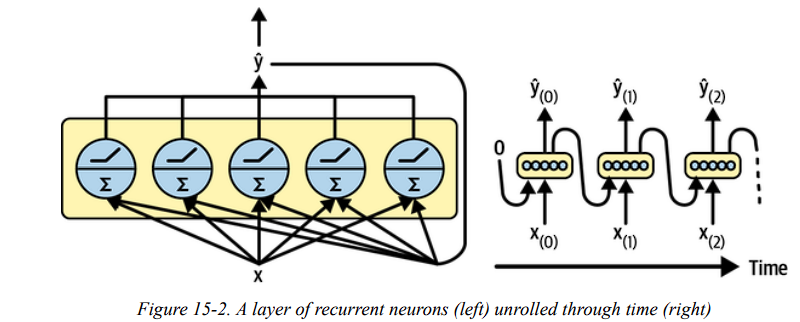

>Note that both the inputs
and outputs are now vectors (when there was just a single neuron, the
output was a scalar).

4. Each recurrent neuron has two sets of weights: one for the inputs x_t and
the other for the outputs of the previous time step, ŷ_(t-1) . Let’s call these
weight vectors w_x and w_ŷ . If we consider the whole recurrent layer instead
of just one recurrent neuron, we can place all the weight vectors in two
weight matrices: W_x and W_ŷ .

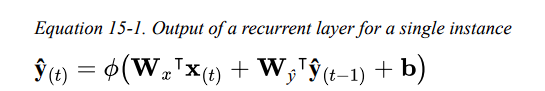

where b is the bias
vector and ϕ(·) is the activation function.


5. we can compute a recurrent
layer’s output in one shot for an entire mini-batch by placing all the inputs
at time step t into an input matrix X_t (see Equation 15-2).

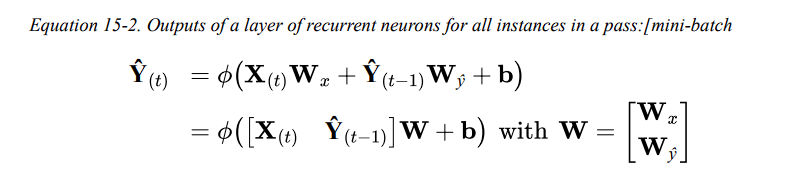

In This Equation:

* Ŷ_t is an m × n_(neurons) matrix containing the layer’s outputs at time step
t for each instance in the mini-batch (m is the number of instances in
the mini-batch and n_(neurons) is the number of neurons).

* X_t is an m × n_inputs matrix containing the inputs for all instances
(n_inputs is the number of input features).

* W_x is an n_(inputs) × n_(neurons) matrix containing the connection weights for
the inputs of the current time step.

* b is a vector of size n_(neurons) containing each neuron’s bias term.

* The weight matrices W_x and W_ŷ are often concatenated vertically into
a single weight matrix W of shape (n_(inputs) + n_(neurons) ) × n_(neurons) (see the
second line of Equation 15-2).

* The notation [X_t Ŷ_(t-1) ] represents the horizontal concatenation of the
matrices X_t and Ŷ_(t-1).

* Notice that Ŷ_t is a function of X_t and Ŷ_(t-1) , which is a function of X_(t-1)
and Ŷ_(t-2) , which is a function of X_(t-2) and Ŷ_(t-3) , and so on. This makes
Ŷ_(t) a function of all the inputs since time t = 0 (that is, X_0 , X_1 , …, X_t ).
At the first time step, t = 0, there are no previous outputs, so they are
typically assumed to be all zeros.






### Memory Cells

1. Since the output of a recurrent neuron at time step t is a function of all the
inputs from previous time steps, you could say it has a form of memory.

2.  A
part of a neural network that preserves some state across time steps is called
a memory cell (or simply a cell).

3. A cell’s state at time step t, denoted h_t (the “h” stands for “hidden”), is a
function of some inputs at that time step and its state at the previous time
step: h_t = f(x_(t) , h_(t-1) ).

4. Its output at time step t, denoted ŷ_t , is also a
function of the previous state and the current inputs. In the case of the basic
cells we have discussed so far, the output is just equal to the state, but in
more complex cells this is not always the case, as shown in Figure 15-3.

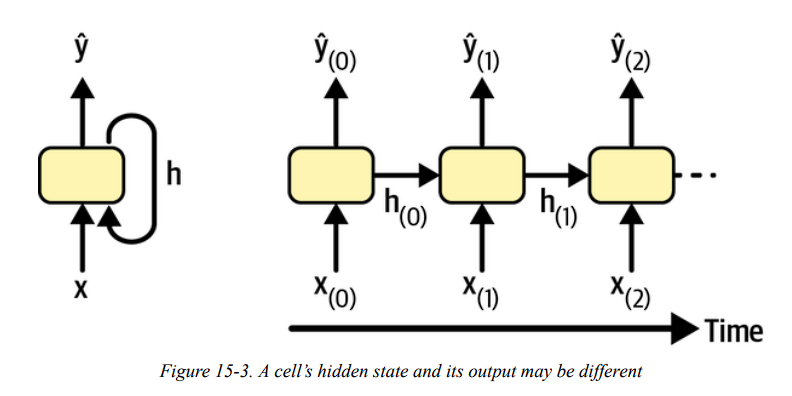




### Input & Output Sequences

1. An RNN can simultaneously take a sequence of inputs and produce a
sequence of outputs (see the top-left network in Figure 15-4). This type of
sequence-to-sequence network is useful to forecast time series, such as your
home’s daily power consumption: you feed it the data over the last N days,
and you train it to output the power consumption shifted by one day into the
future (i.e., from N – 1 days ago to tomorrow).

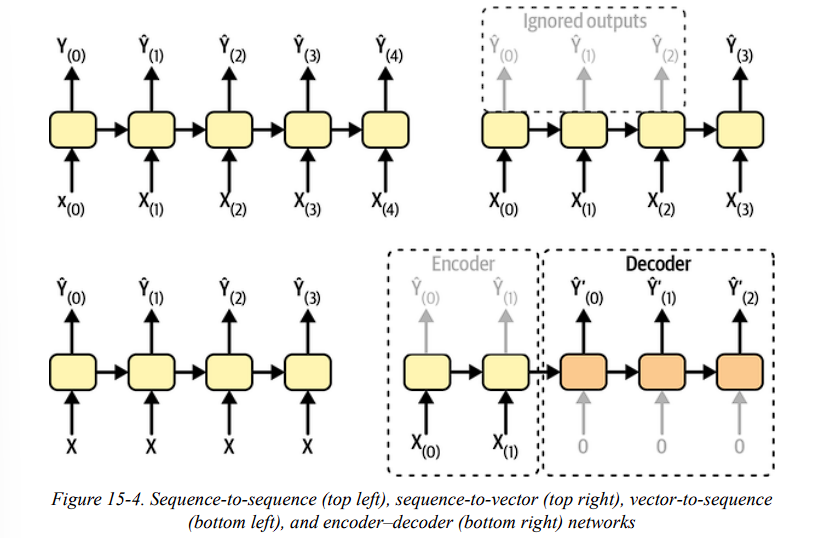

2. you could feed the network a sequence of inputs and ignore
all outputs except for the last one (see the top-right network in Figure 15-4).
This is a sequence-to-vector network. For example, you could feed the
network a sequence of words corresponding to a movie review, and the
network would output a sentiment score (e.g., from 0 [hate] to 1 [love]).

3. you could feed the network the same input vector over and over
again at each time step and let it output a sequence (see the bottom-left
network of Figure 15-4). This is a vector-to-sequence network. For
example, the input could be an image (or the output of a CNN), and the
output could be a caption for that image.

4. you could have a sequence-to-vector network, called an encoder,
followed by a vector-to-sequence network, called a decoder (see the
bottom-right network of Figure 15-4). For example, this could be used for
translating a sentence from one language to another. You would feed the
network a sentence in one language, the encoder would convert this
sentence into a single vector representation, and then the decoder would
decode this vector into a sentence in another language. This two-step
model, called an encoder–decoder. 



### Training RNNs

1. backpropagation through time (BPTT):

* unroll it through time (like we just did) and
then use regular backpropagation.

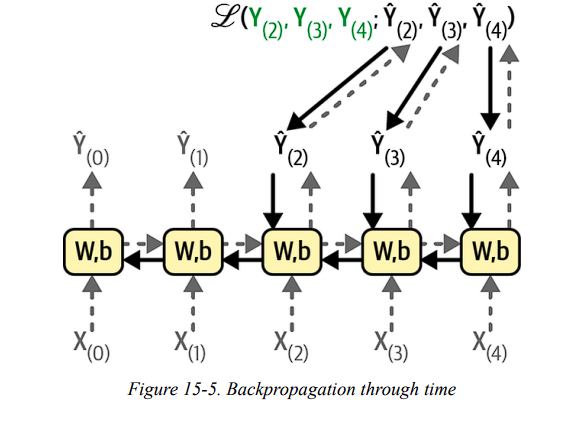

* there is a first forward pass through the
unrolled network (represented by the dashed arrows). Then the output
sequence is evaluated using a loss function ℒ(Y_0 , Y_1 , …, Y_T ; Ŷ_0 , Ŷ_1 ,
…, Ŷ_T ) (where Y_i is the i^th target, Ŷ_i is the i^th prediction, and T is the
max time step).

* The gradients of that loss function are then
propagated backward through the unrolled network (represented by the
solid arrows).

*  since the same parameters
W and b are used at each time step, their gradients will be tweaked multiple
times during backprop.

* Once the backward phase is complete and all the
gradients have been computed, BPTT can perform a gradient descent step
to update the parameters.



### Forecasting a Time series

Let’s pretend you’ve just been hired as a data scientist by
Chicago’s Transit Authority. Your first task is to build a model capable of
forecasting the number of passengers that will ride on bus and rail the next
day. You have access to daily ridership data since 2001. Let’s walk through
together how you would handle this. We’ll start by loading and cleaning up
the data

In [3]:
import tensorflow as tf
from pathlib import Path

filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [8]:
import pandas as pd

df = pd.read_csv(ridership_path / "CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

We load the CSV file, set short column names, sort the rows by date,
remove the redundant total column, and drop duplicate rows. Now let’s
check what the first few rows look like:

In [ ]:
"""The day_type column contains W for Weekdays, A
for Saturdays, and U for Sundays or holidays"""
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


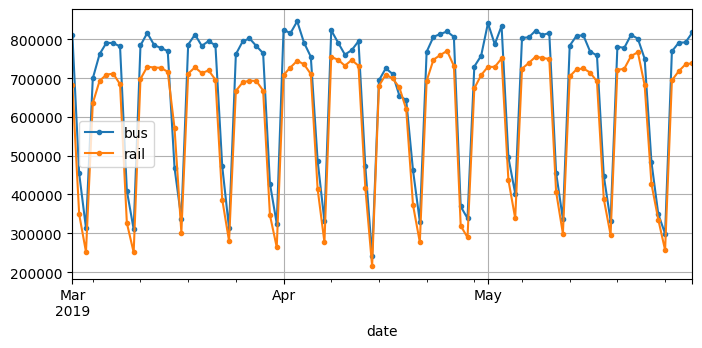

In [10]:
"""Now let’s plot the bus and rail ridership figures over a few months in 2019"""

import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".",figsize=(8,3.5))
plt.show()

 since there are multiple values per time step,
this is called a multivariate time series

If we only looked at the bus
column, it would be a univariate time series, with a single value per time
step

we can see that a similar pattern is clearly repeated
every week. This is called a weekly seasonality. In fact, it’s so strong in this
case that forecasting tomorrow’s ridership by just copying the values from a
week earlier will yield reasonably good results. This is called naive
forecasting: simply copying a past value to make our forecast. Naive
forecasting is often a great baseline, and it can even be tricky to beat in
some cases.


To visualize these naive forecasts, let’s overlay the two time series (for bus
and rail) as well as the same time series lagged by one week (i.e., shifted
toward the right) using dotted lines. We’ll also plot the difference between
the two (i.e., the value at time t minus the value at time t – 7); this is called
differencing

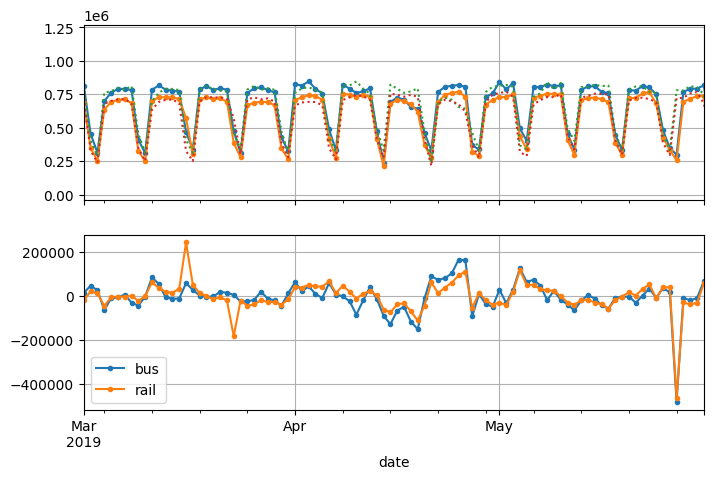

In [11]:
diff_7 = df[["bus","rail"]].diff(7)["2019-03":"2019-05"]
fig, axs = plt.subplots(2,1,sharex=True,figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker=".") # origianl time series
df.shift(7).plot(ax=axs[0],grid=True,legend=False,linestyle=":") #lagged
diff_7.plot(ax=axs[1],grid=True,marker=".") # 7-day difference time series
plt.show()

* Notice how closely the lagged time series track the actual time
series. When a time series is correlated with a lagged version of itself, we
say that the time series is autocorrelated.



In [12]:
"""As you can see, most of the
differences are fairly small, except at the end of May. Maybe there was a
holiday at that time? Let’s check the day_type column:"""

list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed, there was a long weekend back then: the Monday was the Memorial
Day holiday. We could use this column to improve our forecasts, but for
now let’s just measure the mean absolute error over the three-month period
we’re arbitrarily focusing on—March, April, and May 2019—to get a rough
idea:


In [13]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about
42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so
let’s put the forecast errors into perspective by dividing them by the target
values:


In [14]:
targets = df[["bus","rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

What we just computed is called the mean absolute percentage error
(MAPE): it looks like our naive forecasts give us a MAPE of roughly 8.3%
for bus and 9.0% for rail. It’s interesting to note that the MAE for the rail
forecasts looks slightly better than the MAE for the bus forecasts, while the
opposite is true for the MAPE. That’s because the bus ridership is larger
than the rail ridership, so naturally the forecast errors are also larger, but
when we put the errors into perspective, it turns out that the bus forecasts
are actually slightly better than the rail forecasts

>TIP
The MAE, MAPE, and MSE are among the most common metrics you can use to
evaluate your forecasts. As always, choosing the right metric depends on the task. For
example, if your project suffers quadratically more from large errors than from small
ones, then the MSE may be preferable, as it strongly penalizes large errors.


Looking at the time series, there doesn’t appear to be any significant
monthly seasonality, but let’s check whether there’s any yearly seasonality.
We’ll look at the data from 2001 to 2019. To reduce the risk of data
snooping, we’ll ignore more recent data for now. Let’s also plot a 12-month
rolling average for each series to visualize long-term trends

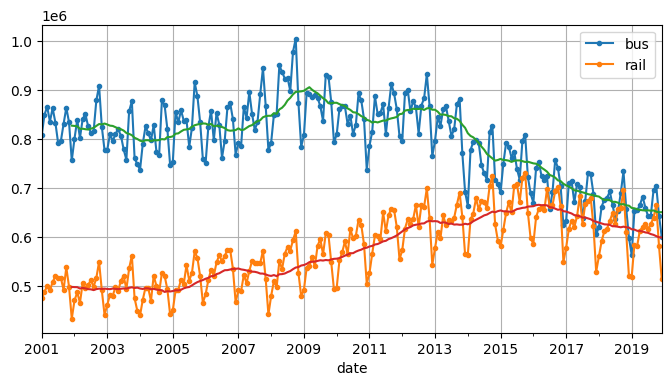

In [17]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

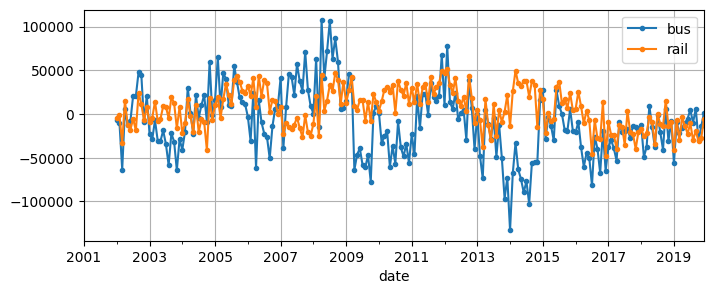

In [18]:
"""Yep! There’s definitely some yearly seasonality as well, although it is
noisier than the weekly seasonality, and more visible for the rail series than
the bus series: we see peaks and troughs at roughly the same dates each
year. Let’s check what we get if we plot the 12-month difference"""

df_monthly.diff(12)[period].plot(grid=True,marker=".",figsize=(8,3))
plt.show()

* Notice how differencing not only removed the yearly seasonality, but it also
removed the long-term trends. For example, the linear downward trend
present in the time series from 2016 to 2019 became a roughly constant
negative value in the differenced time series. In fact, differencing is a
common technique used to remove trend and seasonality from a time series:
it’s easier to study a stationary time series, meaning one whose statistical
properties remain constant over time, without any seasonality or trends.

* Once you’re able to make accurate forecasts on the differenced time series,
it’s easy to turn them into forecasts for the actual time series by just adding
back the past values that were previously subtracted.



### The ARMA Model Family

1.  autoregressive moving average (ARMA) model,
developed by Herman Wold in the 1930s: it computes its forecasts using a
simple weighted sum of lagged values and corrects these forecasts by
adding a moving average, very much like we just discussed. Specifically,
the moving average component is computed using a weighted sum of the
last few forecast errors. Equation 15-3 shows how the model makes its
forecasts.

Equation 15-3 : Forecasting using an ARMA model

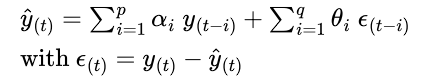

In This Equation:

* ŷ_t is the model’s forecast for time step t.

* y_t is the time series’ value at time step t.

* The first sum is the weighted sum of the past p values of the time
series, using the learned weights α_i . The number p is a hyperparameter,
and it determines how far back into the past the model should look.
This sum is the autoregressive component of the model: it performs
regression based on past values.

* The second sum is the weighted sum over the past q forecast errors ε_t ,
using the learned weights θ_i . The number q is a hyperparameter. This
sum is the moving average component of the model.

2. Importantly, this model assumes that the time series is stationary. If it is not,
then differencing may help. Using differencing over a single time step will
produce an approximation of the derivative of the time series: indeed, it will
give the slope of the series at each time step. This means that it will
eliminate any linear trend, transforming it into a constant value. For
example, if you apply one-step differencing to the series [3, 5, 7, 9, 11], you
get the differenced series [2, 2, 2, 2].

* running d consecutive rounds of differencing computes an
approximation of the dth order derivative of the time series, so it will
eliminate polynomial trends up to degree d. This hyperparameter d is called
the order of integration.


3. Differencing is the central contribution of the autoregressive integrated
moving average (ARIMA) model. this model runs
d rounds of differencing to make the time series more stationary, then it
applies a regular ARMA model. When making forecasts, it uses this ARMA
model, then it adds back the terms that were subtracted by differencing.

4. One last member of the ARMA family is the seasonal ARIMA (SARIMA)
model: it models the time series in the same way as ARIMA, but it
additionally models a seasonal component for a given frequency (e.g.,
weekly), using the exact same ARIMA approach. It has a total of seven
hyperparameters: the same p, d, and q hyperparameters as ARIMA, plus
additional P, D, and Q hyperparameters to model the seasonal pattern, and
lastly the period of the seasonal pattern, noted s. The hyperparameters P, D,
and Q are just like p, d, and q, but they are used to model the time series at
t – s, t – 2s, t – 3s, etc.

Let’s see how to fit a SARIMA model to the rail time series, and use it to
make a forecast for tomorrow’s ridership. We’ll pretend today is the last day
of May 2019, and we want to forecast the rail ridership for “tomorrow”, the
1st of June, 2019. For this, we can use the statsmodels library, which
contains many different statistical models, including the ARMA model and
its variants, implemented by the ARIMA class:

In [20]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01","2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(
    rail_series,
    order=(1,0,0),
    seasonal_order = (0,1,1,7)
)

model = model.fit()
y_pred = model.forecast() 

In [21]:
y_pred

2019-06-01    427758.626222
Freq: D, dtype: float64

In this code example:

* We start by importing the ARIMA class, then we take the rail ridership
data from the start of 2019 up to “today”, and we use asfreq("D") to
set the time series’ frequency to daily: this doesn’t change the data at
all in this case, since it’s already daily, but without this the ARIMA class
would have to guess the frequency, and it would display a warning.

* Next, we create an ARIMA instance, passing it all the data until “today”,
and we set the model hyperparameters: order=(1, 0, 0) means that
p = 1, d = 0, q = 0, and seasonal_order=(0, 1, 1, 7) means that P
= 0, D = 1, Q = 1, and s = 7. Notice that the statsmodels API differs
a bit from Scikit-Learn’s API, since we pass the data to the model at
construction time, instead of passing it to the fit() method.

* Next, we fit the model, and we use it to make a forecast for
“tomorrow”, the 1st of June, 2019.

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes,
we’re 12.9% off—that’s pretty bad. It’s actually slightly worse than naive
forecasting, which forecasts 426,932, off by 12.6%. But perhaps we were
just unlucky that day? To check this, we can run the same code in a loop to
make forecasts for every day in March, April, and May, and compute the
MAE over that period:


In [24]:
origin, start_date, end_date = "2019-01-01","2019-03-01","2019-05-31"
time_period = pd.date_range(start_date,end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    
    model = model.fit() # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds,index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

C:\Users\haide\AppData\Local\Temp\ipykernel_33200\826100552.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\haide\AppData\Local\Temp\ipykernel_33200\826100552.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\haide\AppData\Local\Temp\ipykernel_33200\826100552.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\h

In [25]:
mae

32040.720090488467

Ah, that’s much better! The MAE is about 32,041, which is significantly
lower than the MAE we got with naive forecasting (42,143). So although
the model is not perfect, it still beats naive forecasting by a large margin, on
average.
`

Good p, q, P, and Q values are usually fairly small
(typically 0 to 2, sometimes up to 5 or 6), and d and D are typically 0 or 1,
sometimes 2. As for s, it’s just the main seasonal pattern’s period: in our
case it’s 7 since there’s a strong weekly seasonality. The model with the
lowest MAE wins. Of course, you can replace the MAE with another metric
if it better matches your business objective

### Preparing the Data for Machine Learning Models

1. Our goal will be to forecast
tomorrow’s ridership based on the ridership of the past 8 weeks of data (56
days). The inputs to our model will therefore be sequences (usually a single
sequence per day once the model is in production), each containing 56
values from time steps t – 55 to t. For each input sequence, the model will
output a single value: the forecast for time step t + 1.

2. But what will we use as training data? Well, that’s the trick: we will use
every 56-day window from the past as training data, and the target for each
window will be the value immediately following it.


Keras actually has a nice utility function called
tf.keras.utils.timeseries_dataset_from_array() to help us prepare
the training set. It takes a time series as input, and it builds a tf.data.Dataset
(introduced in Chapter 13) containing all the windows of the desired length,
as well as their corresponding targets

In [26]:
"""example that takes a time
series containing the numbers 0 to 5 and creates a dataset containing all the
windows of length 3, with their corresponding targets, grouped into batches
of size 2"""

import tensorflow as tf

my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], #the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)

In [27]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

Each sample in the dataset is a window of length 3, along with its
corresponding target (i.e., the value immediately after the window). The
windows are [0, 1, 2], [1, 2, 3], and [2, 3, 4], and their respective targets are
3, 4, and 5. Since there are three windows in total, which is not a multiple
of the batch size, the last batch only contains one window instead of two.

Another way to get the same result is to use the window() method of
tf.data’s Dataset class. It’s more complex, but it gives you full control

In [28]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}",end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In this example, the dataset contains six windows, each shifted by one step
compared to the previous one, and the last three windows are smaller
because they’ve reached the end of the series. In general you’ll want to get
rid of these smaller windows by passing drop_remainder=True to the
window() method.


* The window() method returns a nested dataset, analogous to a list of lists.
This is useful when you want to transform each window by calling its
dataset methods (e.g., to shuffle them or batch them). However, we cannot
use a nested dataset directly for training, as our model will expect tensors as
input, not datasets.

* Therefore, we must call the flat_map() method: it converts a nested
dataset into a flat dataset (one that contains tensors, not datasets). For
example, suppose {1, 2, 3} represents a dataset containing the sequence of
tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}},
you get back the flat dataset {1, 2, 3, 4, 5, 6}.

* Moreover, the flat_map() method takes a function as an argument, which
allows you to transform each dataset in the nested dataset before flattening.
For example, if you pass the function lambda ds: ds.batch(2) to
flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}}
into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset containing 3 tensors,
each of size 2.



In [29]:
dataset = tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


We now have a
dataset containing consecutive windows represented as tensors. Let’s create
a little helper function to make it easier to extract windows from a dataset:

In [30]:
def to_windows(dataset,length):
    dataset = dataset.window(length,shift=1,drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

The last step is to split each window into inputs and targets, using the map()
method. We can also group the resulting windows into batches of size 2:

In [32]:
dataset = to_windows(tf.data.Dataset.range(6),4) # 3 inputs + 1 target = 4
dataset = dataset.map(lambda window: (window[:-1],window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

As you can see, we now have the same output as we got earlier with the
timeseries_dataset_from_array() function (with a bit more effort, but
it will be worthwhile soon).

Now, before we start training, we need to split our data into a training
period, a validation period, and a test period. We will focus on the rail
ridership for now. We will also scale it down by a factor of one million, to
ensure the values are near the 0–1 range; this plays nicely with the default
weight initialization and learning rate:

In [33]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6


> NOTE
When dealing with time series, you generally want to split across time. However, in
some cases you may be able to split along other dimensions, which will give you a
longer time period to train on. For example, if you have data about the financial health
of 10,000 companies from 2001 to 2019, you might be able to split this data across the
different companies. It’s very likely that many of these companies will be strongly
correlated, though (e.g., whole economic sectors may go up or down jointly), and if you
have correlated companies across the training set and the test set, your test set will not
be as useful, as its measure of the generalization error will be optimistically biased.

Next, let’s use timeseries_dataset_from_array() to create datasets for
training and validation. Since gradient descent expects the instances in the
training set to be independent and identically distributed (IID), as we saw in
Chapter 4, we must set the argument shuffle=True to shuffle the training
windows (but not their contents):


In [34]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length = seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets = rail_valid[seq_length:],
    sequence_length = seq_length,
    batch_size=32
)


### Forecasting Using a Linear Model

Let’s try a basic linear model first. We will use the Huber loss, which
usually works better than minimizing the MAE directly. We'll also use early stopping.

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",patience=50,restore_best_weights=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_ds,
                    validation_data=(valid_ds),
                    epochs=500,
                    callbacks=[early_stopping_cb])



Epoch 1/500


C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2452 - mae: 0.5762 - val_loss: 0.0128 - val_mae: 0.1289
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - mae: 0.1318 - val_loss: 0.0096 - val_mae: 0.1089
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mae: 0.0988 - val_loss: 0.0095 - val_mae: 0.1083
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - mae: 0.1014 - val_loss: 0.0075 - val_mae: 0.0899
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - mae: 0.0816 - val_loss: 0.0071 - val_mae: 0.0863
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - mae: 0.0790 - val_loss: 0.0064 - val_mae: 0.0821
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - mae: 0.0725 - val_loss: 0.0062 - val_mae: 0.0832
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - mae: 0.0698 - val_loss: 0.0057 - val_mae: 0.0761
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.

In [36]:
valid_loss,valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - mae: 0.0390


37709.57142114639

This model reaches a validation MAE of about 37,866 (your mileage may
vary). That’s better than naive forecasting, but worse than the SARIMA
model

### Forecasting Using a Simple RNN

Let’s try the most basic RNN, containing a single recurrent layer with just
one recurrent neuron

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


* All recurrent layers in Keras expect 3D inputs of shape [batch size, time
steps, dimensionality], where dimensionality is 1 for univariate time series
and more for multivariate time series.

* Recall that the input_shape
argument ignores the first dimension (i.e., the batch size), and since
recurrent layers can accept input sequences of any length, we can set the
second dimension to None, which means “any size”.

* Lastly, since we’re
dealing with a univariate time series, we need the last dimension’s size to be
1 . This is why we specified the input shape [None, 1].

*  Note that the datasets actually contain
inputs of shape [batch size, time steps], so we’re missing the last dimension,
of size 1, but Keras is kind enough to add it for us in this case.

* This model works exactly as we saw earlier: the initial state h_(init) is set to 0,
and it is passed to a single recurrent neuron, along with the value of the first
time step, x_0 . The neuron computes a weighted sum of these values plus
the bias term, and it applies the activation function to the result, using the
hyperbolic tangent function by default. The result is the first output, y_0 . In a
simple RNN, this output is also the new state h_0 . This new state is passed to
the same recurrent neuron along with the next input value, x_1 , and the
process is repeated until the last time step. At the end, the layer just outputs
the last value: in our case the sequences are 56 steps long, so the last value
is y_55 . All of this is performed simultaneously for every sequence in the
batch, of which there are 32 in this case.

>NOTE
By default, recurrent layers in Keras only return the final output. To make them return
one output per time step, you must set return_sequences=True, as you will see.

* Now if you compile, train, and evaluate this model just like the previous
    model, you will find that it’s no good at all: its validation MAE is greater
    than 100,000! Ouch. That was to be expected, for two reasons:


    * . The model only has a single recurrent neuron, so the only data it can
    use to make a prediction at each time step is the input value at the
    current time step and the output value from the previous time step.
    That’s not much to go on! In other words, the RNN’s memory is
    extremely limited: it’s just a single number, its previous output. And
    let’s count how many parameters this model has: since there’s just one
    recurrent neuron with only two input values, the whole model only has
    three parameters (two weights plus a bias term). That’s far from
    enough for this time series. In contrast, our previous model could look
    at all 56 previous values at once, and it had a total of 57 parameters.

    * The time series contains values from 0 to about 1.4, but since the
    default activation function is tanh, the recurrent layer can only output
    values between –1 and +1. There’s no way it can predict values
    between 1.0 and 1.4.

* Solutions:

    * we will create a model with a larger recurrent
    layer, containing 32 recurrent neurons, and we will add a dense output layer
    on top of it with a single output neuron and no activation function.
    The
    recurrent layer will be able to carry much more information from one time
    step to the next, and the dense output layer will project the final output from
    32 dimensions down to 1, without any value range constraints:


In [40]:
univar_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1) # No activation function by default
])

In [41]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [42]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0531 - mae: 0.2308 - val_loss: 0.0050 - val_mae: 0.0838
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0748 - val_loss: 0.0028 - val_mae: 0.0550
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0643 - val_loss: 0.0026 - val_mae: 0.0502
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0670 - val_loss: 0.0025 - val_mae: 0.0483
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0570 - val_loss: 0.0026 - val_mae: 0.0437
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0584 - val_loss: 0.0040 - val_mae: 0.0683
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0557 - val_loss: 0.0022 - val_mae: 0.0392
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0491 - val_loss: 0.0023 - val_mae: 0.0401
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0

28678.12104523182

Now if you compile, fit, and evaluate this model just like the previous one,
you will find that its validation MAE reaches 27,703. That’s the best model
we’ve trained so far, and it even beats the SARIMA model: we’re doing
pretty well!


>TIP
We’ve only normalized the time series, without removing trend and seasonality, and yet
the model still performs well. This is convenient, as it makes it possible to quickly
search for promising models without worrying too much about preprocessing. However,
to get the best performance, you may want to try making the time series more stationary;
for example, using differencing.

### Forecasting Using a Deep RNN

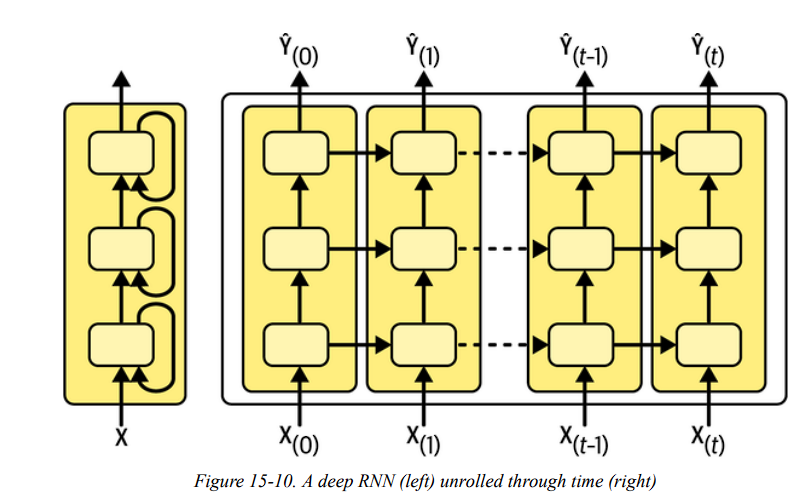

1. In the following example, we use three SimpleRNN layers
(but we could use any other type of recurrent layer instead, such as an LSTM
layer or a GRU layer, which we will discuss shortly). The first two are
sequence-to-sequence layers, and the last one is a sequence-to-vector layer.
Finally, the Dense layer produces the model’s forecast (you can think of it
as a vector-to-vector layer). So this model is just like the model represented
in Figure 15-10, except the outputs Ŷ_0 to Ŷ_(t-1) are ignored, and there’s a
dense layer on top of Ŷ_t , which outputs the actual forecast:



In [44]:
deep_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

>WARNING
Make sure to set return_sequences=True for all recurrent layers (except the last one,
if you only care about the last output). If you forget to set this parameter for one
recurrent layer, it will output a 2D array containing only the output of the last time step,
instead of a 3D array containing outputs for all time steps. The next recurrent layer will
complain that you are not feeding it sequences in the expected 3D format.



In [45]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.1426 - mae: 0.4375 - val_loss: 0.0334 - val_mae: 0.1880
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0273 - mae: 0.1869 - val_loss: 0.0159 - val_mae: 0.1628
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0169 - mae: 0.1603 - val_loss: 0.0161 - val_mae: 0.1415
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0217 - mae: 0.1747 - val_loss: 0.0172 - val_mae: 0.1317
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0215 - mae: 0.1752 - val_loss: 0.0232 - val_mae: 0.1297
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0175 - mae: 0.1565 - val_loss: 0.0171 - val_mae: 0.1769
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0292 - mae: 0.2009 - val_loss: 0.0198 - val_mae: 0.1225
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0187 - mae: 0.1662 - val_loss: 0.0157 - val_mae: 0.1553
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

31644.538044929504

If you train and evaluate this model, you will find that it reaches an MAE of
about 31,211. That’s better than both baselines, but it doesn’t beat our
“shallower” RNN. It looks like this RNN is a bit too large for our task.

### Forecasting Multivariate Time Series

1.  let’s try to forecast the rail time series using both
the bus and rail data as input. In fact, let’s also throw in the day type! Since
we can always know in advance whether tomorrow is going to be a
weekday, a weekend, or a holiday, we can shift the day type series one day
into the future, so that the model is given tomorrow’s day type as input. For
simplicity, we’ll do this processing using Pandas:

In [49]:
df_mulvar = df[["bus","rail"]] / 1e6 
df_mulvar["next_day_type"] = df["day_type"].shift(-1) 
df_mulvar = pd.get_dummies(df_mulvar,dtype=float)

Now df_mulvar is a DataFrame with five columns: the bus and rail data,
plus three columns containing the one-hot encoding of the next day’s type
(recall that there are three possible day types, W, A, and U). Next we can
proceed much like we did earlier. First we split the data into three periods,
for training, validation, and testing:

In [50]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Then we create the datasets:

In [51]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_train["rail"][seq_length:], #forecast only the rail
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets= mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size = 32
)



And finally we create the RNN:

In [54]:
mulvar_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [56]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1475 - mae: 0.4015 - val_loss: 0.0059 - val_mae: 0.0999
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0704 - val_loss: 0.0018 - val_mae: 0.0463
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - mae: 0.0472 - val_loss: 0.0013 - val_mae: 0.0406
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0403 - val_loss: 8.4433e-04 - val_mae: 0.0302
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.0407 - val_loss: 0.0022 - val_mae: 0.0573
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0390 - val_loss: 0.0020 - val_mae: 0.0564
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0391 - val_loss: 0.0015 - val_mae: 0.0452
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012 - mae: 0.0358 - val_loss: 0.0019 - val_mae: 0.0520
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

24811.431765556335

Notice that the only difference from the univar_model RNN we built
earlier is the input shape: at each time step, the model now receives five
inputs instead of one. This model actually reaches a validation MAE of
24k

* using a single model for multiple related
tasks often results in better performance than using a separate model for
each task, since features learned for one task may be useful for the other
tasks, and also because having to perform well across multiple tasks
prevents the model from overfitting (it’s a form of regularization).



### Forecasting Several Time steps ahead

1. So far we have only predicted the value at the next time step, but we could
just as easily have predicted the value several steps ahead by changing the
targets appropriately (e.g., to predict the ridership 2 weeks from now, we
could just change the targets to be the value 14 days ahead instead of 1 day
ahead). But what if we want to predict the next 14 values?

2. The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the
inputs, acting as if the predicted value had actually occurred; we would then
use the model again to predict the following value, and so on, as in the
following code:

In [57]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X,y_pred_one.reshape(1,1,1)],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>WARNING
If the model makes an error at one time step, then the forecasts for the following time
steps are impacted as well: the errors tend to accumulate. So, it’s preferable to use this
technique only for a small number of steps.


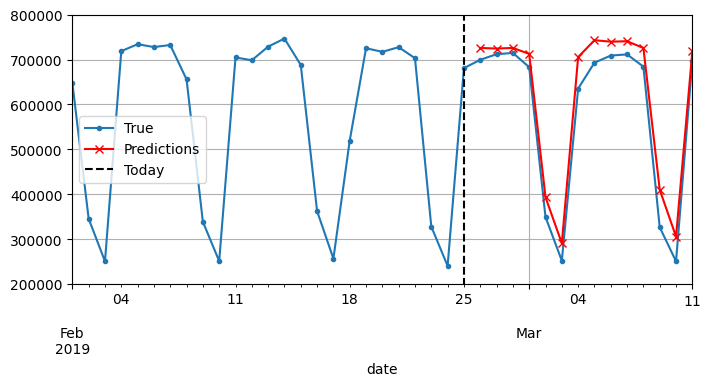

In [58]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

3. The second option is to train an RNN to predict the next 14 values in one
shot. We can still use a sequence-to-vector model, but it will output 14
values instead of 1. However, we first need to change the targets to be
vectors containing the next 14 values. To do this, we can use
timeseries_dataset_from_array() again, but this time asking it to
create datasets without targets (targets=None) and with longer sequences,
of length seq_length + 14. Then we can use the datasets’ map() method to
apply a custom function to each batch of sequences, splitting them into
inputs and targets. In this example, we use the multivariate time series as
input (using all five columns), and we forecast the rail ridership for the next
14 days

In [59]:
def split_inputs_and_targets(mulvar_series,ahead=14,target_col=1):
    return mulvar_series[:,:-ahead],mulvar_series[:,-ahead:,target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size = 32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length = seq_length + 14,
    batch_size = 32
).map(split_inputs_and_targets)

In [60]:
ahead_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(14)
])

In [61]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1105 - mae: 0.3628 - val_loss: 0.0130 - val_mae: 0.1304
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - mae: 0.1303 - val_loss: 0.0072 - val_mae: 0.0923
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0087 - mae: 0.1018 - val_loss: 0.0051 - val_mae: 0.0779
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0874 - val_loss: 0.0041 - val_mae: 0.0712
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - mae: 0.0802 - val_loss: 0.0035 - val_mae: 0.0645
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mae: 0.0773 - val_loss: 0.0033 - val_mae: 0.0625
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0733 - val_loss: 0.0029 - val_mae: 0.0582
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0704 - val_loss: 0.0033 - val_mae: 0.0618
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

34321.267157793045

After training this model, you can predict the next 14 values at once like
this:

In [62]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length] # shape [1,56,5]
Y_pred = ahead_model.predict(X) #shape [ 1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


In [63]:
Y_pred

array([[0.7105929 , 0.7242321 , 0.7412387 , 0.70364404, 0.362809  ,
        0.2701563 , 0.63266987, 0.70101726, 0.7274979 , 0.725452  ,
        0.68089384, 0.3961003 , 0.2571234 , 0.62550294]], dtype=float32)

This approach works quite well. Its forecasts for the next day are obviously
better than its forecasts for 14 days into the future, but it doesn’t accumulate
errors like the previous approach did. However, we can still do better, using
a sequence-to-sequence (or seq2seq) model.

### Forecasting Using a Sequence-to-Sequence Model

1. Instead of training the model to forecast the next 14 values only at the very
last time step, we can train it to forecast the next 14 values at each and
every time step. In other words, we can turn this sequence-to-vector RNN
into a sequence-to-sequence RNN. The advantage of this technique is that
the loss will contain a term for the output of the RNN at each and every
time step, not just for the output at the last time step.

2. This means there will be many more error gradients flowing through the
model, and they won’t have to flow through time as much since they will
come from the output of each time step, not just the last one. This will both
stabilize and speed up training.

3. To be clear, at time step 0 the model will output a vector containing the
forecasts for time steps 1 to 14, then at time step 1 the model will forecast
time steps 2 to 15, and so on. In other words, the targets are sequences of
consecutive windows, shifted by one time step at each time step. The target
is not a vector anymore, but a sequence of the same length as the inputs,
containing a 14-dimensional vector at each step.

4. Preparing the datasets is not trivial, since each instance has a window as
input and a sequence of windows as output. One way to do this is to use the
to_windows() utility function we created earlier, twice in a row, to get
windows of consecutive windows. 

For example, let’s turn the series of
numbers 0 to 6 into a dataset containing sequences of 4 consecutive
windows, each of length 3:


In [64]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series,3),4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

Now we can use the map() method to split these windows of windows into
inputs and targets:

In [65]:
dataset = dataset.map(lambda S: (S[:,0], S[:,1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Now the dataset contains sequences of length 4 as inputs, and the targets are
sequences containing the next two steps, for each time step. For example,
the first input sequence is [0, 1, 2, 3], and its corresponding targets are [[1,
2], [2, 3], [3, 4], [4, 5]], which are the next two values for each time step.

>NOTE:
It may be surprising that the targets contain values that appear in the inputs. Isn’t that
cheating? Fortunately, not at all: at each time step, an RNN only knows about past time
steps; it cannot look ahead. It is said to be a causal model.

Let’s create another little utility function to prepare the datasets for our
sequence-to-sequence model. It will also take care of shuffling (optional)
and batching:

In [66]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(
        lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

Now we can use this function to create the datasets:

In [67]:
seq2seq_train = to_seq2seq_dataset(mulvar_train,shuffle=True,seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

And lastly, we can build the sequence-to-sequence model:


In [68]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.Dense(14)
])

* It is almost identical to our previous model: the only difference is that we
set return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 32), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 32-
dimensional vector as input and outputting a 14-dimensional vector. In fact,
another way to get the exact same result is to use a Conv1D layer with a
kernel size of 1: Conv1D(14, kernel_size=1).

In [69]:
fit_and_evaluate(seq2seq_model,seq2seq_train,seq2seq_valid,learning_rate=0.05)

Epoch 1/500
     32/Unknown 2s 9ms/step - loss: 0.2119 - mae: 0.5255

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2059 - mae: 0.5150 - val_loss: 0.0222 - val_mae: 0.1650
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - mae: 0.1484 - val_loss: 0.0130 - val_mae: 0.1204
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.1144 - val_loss: 0.0099 - val_mae: 0.1030
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.0996 - val_loss: 0.0083 - val_mae: 0.0932
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0891 - val_loss: 0.0071 - val_mae: 0.0843
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0808 - val_loss: 0.0059 - val_mae: 0.0748
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0746 - val_loss: 0.0057 - val_mae: 0.0727
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0692 - val_loss: 0.0051 - val_mae: 0.0665
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - 

48747.602850198746

>TIP
Keras offers a TimeDistributed layer that lets you apply any vector-to-vector layer to
every vector in the input sequences, at every time step. It does this efficiently, by
reshaping the inputs so that each time step is treated as a separate instance, then it
reshapes the layer’s outputs to recover the time dimension. In our case, we don’t need it
since the Dense layer already supports sequences as inputs.

* The training code is the same as usual. During training, all the model’s
outputs are used, but after training only the output of the very last time step
matters, and the rest can be ignored.

For example, we can forecast the rail
ridership for the next 14 days like this:


In [70]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0,-1] #only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [71]:
y_pred_14

array([0.7078379 , 0.69390017, 0.72848094, 0.69419277, 0.36740845,
       0.2641213 , 0.65136486, 0.71899986, 0.72071207, 0.73518735,
       0.6954011 , 0.37890202, 0.2798496 , 0.64697796], dtype=float32)

If you evaluate this model’s forecasts for t + 1, you will find a validation
MAE of 25,519. For t + 2 it’s 26,274, and the performance continues to
drop gradually as the model tries to forecast further into the future. At
t + 14, the MAE is 34,322.

>TIP
You can combine both approaches to forecasting multiple steps ahead: for example, you
can train a model that forecasts 14 days ahead, then take its output and append it to the
inputs, then run the model again to get forecasts for the following 14 days, and possibly
repeat the process.

Simple RNNs can be quite good at forecasting time series or handling other
kinds of sequences, but they do not perform as well on long time series or
sequences.

### Handling Long Sequences

1. To train an RNN on long sequences, we must run it over many time steps,
making the unrolled RNN a very deep network. Just like any deep neural
network it may suffer from the unstable gradients problem, discussed in
Chapter 11: it may take forever to train, or training may be unstable.
Moreover, when an RNN processes a long sequence, it will gradually forget
the first inputs in the sequence.

2. Let’s look at both these problems, starting
with the unstable gradients problem:

* Fighting the Unstable Gradients Problem:

    * Many of the tricks we used in deep nets to alleviate the unstable gradients
    problem can also be used for RNNs: good parameter initialization, faster
    optimizers, dropout, and so on. However, nonsaturating activation functions
    (e.g., ReLU) may not help as much here. In fact, they may actually lead the
    RNN to be even more unstable during training.

    * Why? Well, suppose
    gradient descent updates the weights in a way that increases the outputs
    slightly at the first time step. Because the same weights are used at every
    time step, the outputs at the second time step may also be slightly increased,
    and those at the third, and so on until the outputs explode—and a
    nonsaturating activation function does not prevent that.

    * You can reduce this risk by using a smaller learning rate, or you can use a
    saturating activation function like the hyperbolic tangent (this explains why
    it’s the default).

    * In much the same way, the gradients themselves can explode. If you notice
    that training is unstable, you may want to monitor the size of the gradients
    (e.g., using TensorBoard) and perhaps use gradient clipping.

    * Moreover, batch normalization cannot be used as efficiently with RNNs as
    with deep feedforward nets. In fact, you cannot use it between time steps,
    only between recurrent layers.

    * To be more precise, it is technically possible to add a BN layer to a memory
    cell (as you will see shortly) so that it will be applied at each time step (both
    on the inputs for that time step and on the hidden state from the previous
    step). However, the same BN layer will be used at each time step, with the
    same parameters, regardless of the actual scale and offset of the inputs and
    hidden state. In practice, this does not yield good results. 

    * the authors found
    that BN was slightly beneficial only when it was applied to the layer’s
    inputs, not to the hidden states.

    >NOTE: In Keras, you can
    apply BN between layers simply by adding a BatchNormalization layer
    before each recurrent layer, but it will slow down training, and it may not
    help much.

    * Another form of normalization often works better with RNNs: layer
    normalization. instead of normalizing
    across the batch dimension, layer normalization normalizes across the
    features dimension. One advantage is that it can compute the required
    statistics on the fly, at each time step, independently for each instance. This
    also means that it behaves the same way during training and testing (as
    opposed to BN), and it does not need to use exponential moving averages to
    estimate the feature statistics across all instances in the training set, like BN
    does. Like BN, layer normalization learns a scale and an offset parameter
    for each input. In an RNN, it is typically used right after the linear
    combination of the inputs and the hidden states.

Let’s use Keras to implement layer normalization within a simple memory
cell. To do this, we need to define a custom memory cell, which is just like
a regular layer, except its call() method takes two arguments: the inputs
at the current time step and the hidden states from the previous time step.


>Note that the states argument is a list containing one or more tensors. In
the case of a simple RNN cell it contains a single tensor equal to the outputs
of the previous time step, but other cells may have multiple state tensors
(e.g., an LSTMCell has a long-term state and a short-term state, as you will
see shortly). A cell must also have a state_size attribute and an
output_size attribute. In a simple RNN, both are simply equal to the
number of units. The following code implements a custom memory cell that
will behave like a SimpleRNNCell, except it will also apply layer
normalization at each time step


In [75]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self,units,activation="tanh",**kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self,inputs,states):
        outputs, new_states = self.simple_rnn_cell(inputs,states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Let’s walk through this code:

* Our LNSimpleRNNCell class inherits from the
tf.keras.layers.Layer class, just like any custom layer.

* The constructor takes the number of units and the desired activation
function and sets the state_size and output_size attributes, then
creates a SimpleRNNCell with no activation function (because we
want to perform layer normalization after the linear operation but
before the activation function). Then the constructor creates the
LayerNormalization layer, and finally it fetches the desired
activation function.

* The call() method starts by applying the simpleRNNCell, which
computes a linear combination of the current inputs and the previous
hidden states, and it returns the result twice (indeed, in a
SimpleRNNCell, the outputs are just equal to the hidden states: in
other words, new_states[0] is equal to outputs, so we can safely
ignore new_states in the rest of the call() method). Next, the
call() method applies layer normalization, followed by the activation
function. Finally, it returns the outputs twice: once as the outputs, and
once as the new hidden states. To use this custom cell, all we need to
do is create a tf.keras.layers.RNN layer, passing it a cell instance:


In [76]:
custom_ln_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.RNN(LNSimpleRNNCell(32),return_sequences=True),
    tf.keras.layers.Dense(14)
])

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Similarly, you could create a custom cell to apply dropout between each
time step. But there’s a simpler way: most recurrent layers and cells
provided by Keras have dropout and recurrent_dropout
hyperparameters: the former defines the dropout rate to apply to the inputs,
and the latter defines the dropout rate for the hidden states, between time
steps. So, there’s no need to create a custom cell to apply dropout at each
time step in an RNN.

With these techniques, you can alleviate the unstable gradients problem and
train an RNN much more efficiently. Now let’s look at how to deal with the
short-term memory problem.

>TIP
When forecasting time series, it is often useful to have some error bars along with your
predictions. For this, one approach is to use MC dropout, introduced in Chapter 11: use
recurrent_dropout during training, then keep dropout active at inference time by
calling the model using model(X, training=True). Repeat this several times to get
multiple slightly different forecasts, then compute the mean and standard deviation of
these predictions for each time step.



* Tackling the Short-Term Memory Problem:

    * Due to the transformations that the data goes through when traversing an
    RNN, some information is lost at each time step. After a while, the RNN’s
    state contains virtually no trace of the first inputs.

    * LSTM cells: The long short-term memory cell. If you consider the LSTM cell as a black box, it can be used
    very much like a basic cell, except it will perform much better; training will
    converge faster, and it will detect longer-term patterns in the data.



In [77]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.Dense(14)
])

>Alternatively, you could use the general-purpose tf.keras.layers.RNN
layer, giving it an LSTMCell as an argument. However, the LSTM layer uses
an optimized implementation when running on a GPU.

* So how does an LSTM cell work? Its architecture is shown in Figure 15-12.
If you don’t look at what’s inside the box, the LSTM cell looks exactly like
a regular cell, except that its state is split into two vectors: h_t and c_t (“c”
stands for “cell”). You can think of h_t as the short-term state and c_t as the
long-term state.

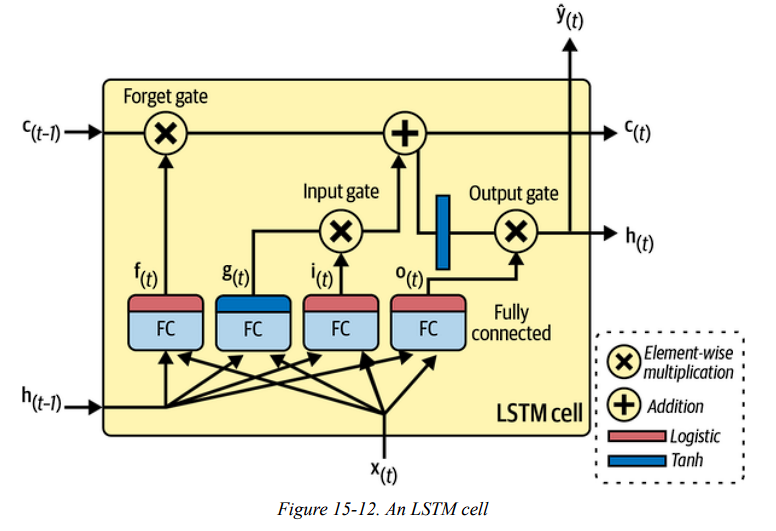

* The key idea is that the network can learn what to
store in the long-term state, what to throw away, and what to read from it.
As the long-term state c_(t-1) traverses the network from left to right, you can
see that it first goes through a forget gate, dropping some memories, and
then it adds some new memories via the addition operation (which adds the
memories that were selected by an input gate).

* The result c_t is sent straight
out, without any further transformation. So, at each time step, some
memories are dropped and some memories are added. Moreover, after the
addition operation, the long-term state is copied and passed through the
tanh function, and then the result is filtered by the output gate

* This
produces the short-term state h_t (which is equal to the cell’s output for this
time step, y_t )

* Now let’s look at where new memories come from and how
    the gates work:
    *  First, the current input vector x_t and the previous short-term state h_(t-1) are
        fed to four different fully connected layers. They all serve a different
        purpose:
        
        * The main layer is the one that outputs g_t . It has the usual role of
        analyzing the current inputs x_t and the previous (short-term) state h_(t-1)
        . In a basic cell, there is nothing other than this layer, and its output
        goes straight out to y_t and h_t . But in an LSTM cell, this layer’s
        output does not go straight out; instead its most important parts are
        stored in the long-term state (and the rest is dropped).

        * The three other layers are gate controllers. Since they use the logistic
            activation function, the outputs range from 0 to 1. As you can see, the
            gate controllers’ outputs are fed to element-wise multiplication
            operations: if they output 0s they close the gate, and if they output 1s
            they open it. Specifically:

            *  The forget gate (controlled by f_t ) controls which parts of the
                long-term state should be erased.
            
            *  The input gate (controlled by i_t) controls which parts of g
                should be added to the long-term state.
            
            * Finally, the output gate (controlled by o_t ) controls which parts of
            the long-term state should be read and output at this time step,both to h_t and to y_t .

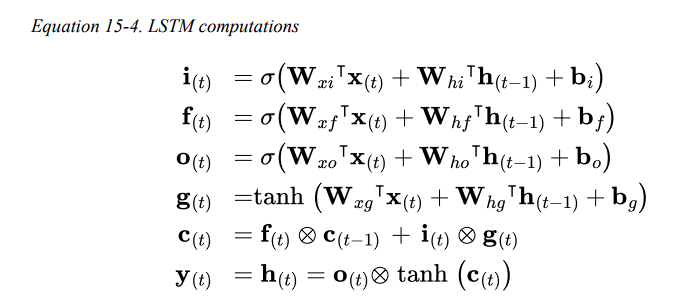

In this equation:

* W_xi , W_xf , W_xo , and W_xg are the weight matrices of each of the four
layers for their connection to the input vector x_t .

* W_hi , W_hf , W_ho , and W_hg are the weight matrices of each of the four
layers for their connection to the previous short-term state h_(t-1) .

* b_i , b_f , b_o , and b_g are the bias terms for each of the four layers. Note
that TensorFlow initializes b to a vector full of 1s instead of 0s. This
prevents forgetting everything at the beginning of training.



* GRU Cells: The gated recurrent unit (GRU) cell

    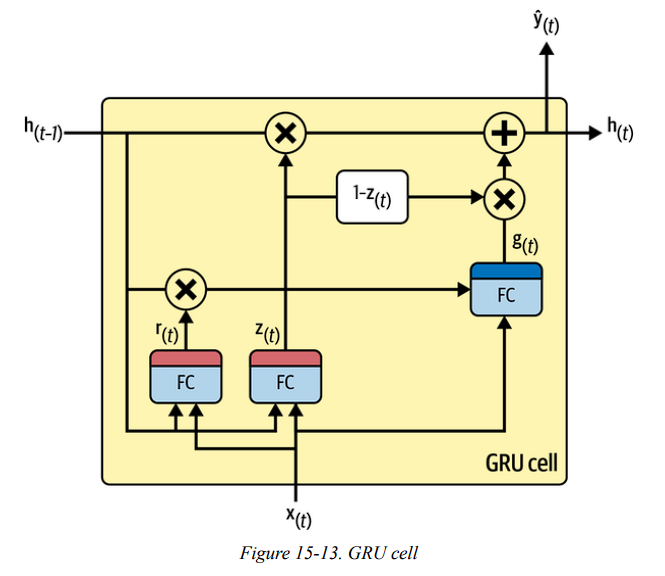

    * The GRU cell is a simplified version of the LSTM cell, These are
        the main simplifications:
        *    Both state vectors are merged into a single vector h_t .

        * A single gate controller z_t controls both the forget gate and the input
        gate. If the gate controller outputs a 1, the forget gate is open (= 1) and
        the input gate is closed (1 – 1 = 0). If it outputs a 0, the opposite
        happens. In other words, whenever a memory must be stored, the
        location where it will be stored is erased first. This is actually a
        frequent variant to the LSTM cell in and of itself.

        * There is no output gate; the full state vector is output at every time
        step. However, there is a new gate controller r_t that controls which
        part  of the previous state will be shown to the main layer (g_t ).

    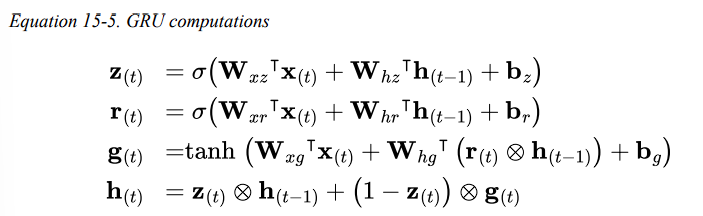
 



### Using 1D Convolutional layers to process sequences

1. a 1D convolutional layer slides
several kernels across a sequence, producing a 1D feature map per kernel.
Each kernel will learn to detect a single very short sequential pattern (no
longer than the kernel size). If you use 10 kernels, then the layer’s output
will be composed of 10 1D sequences (all of the same length), or
equivalently you can view this output as a single 10D sequence.

For example, the following model is the same as earlier, except it starts with
a 1D convolutional layer that downsamples the input sequence by a factor
of 2, using a stride of 2. The kernel size is larger than the stride, so all
inputs will be used to compute the layer’s output, and therefore the model
can learn to preserve the useful information, dropping only the unimportant
details. By shortening the sequences the convolutional layer may help the
GRU layers detect longer patterns, so we can afford to double the input
sequence length to 112 days. Note that we must also crop off the first three
time steps in the targets: indeed, the kernel’s size is 4, so the first output of
the convolutional layer will be based on the input time steps 0 to 3, and the
first forecasts will be for time steps 4 to 17 (instead of time steps 1 to 14).
Moreover, we must downsample the targets by a factor of 2, because of the
stride:

In [78]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=[None,5]),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=4,
                           strides=2,
                           activation="relu"),
    tf.keras.layers.GRU(32,return_sequences=True),
    tf.keras.layers.Dense(14)
])

In [79]:
longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                  shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid,seq_length=112)
downsampled_train = longer_train.map(lambda X,Y: (X,Y[:,3::2]))
downsampled_valid = longer_valid.map(lambda X,Y: (X,Y[:,3::2]))

fit_and_evaluate(conv_rnn_model,downsampled_train,downsampled_valid,learning_rate=0.05)

Epoch 1/500
     31/Unknown 3s 18ms/step - loss: 0.1207 - mae: 0.4035

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1189 - mae: 0.3995 - val_loss: 0.0207 - val_mae: 0.1633
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0180 - mae: 0.1614 - val_loss: 0.0174 - val_mae: 0.1456
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0151 - mae: 0.1458 - val_loss: 0.0159 - val_mae: 0.1390
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0138 - mae: 0.1391 - val_loss: 0.0148 - val_mae: 0.1329
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0128 - mae: 0.1324 - val_loss: 0.0137 - val_mae: 0.1271
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0118 - mae: 0.1261 - val_loss: 0.0128 - val_mae: 0.1220
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0109 - mae: 0.1202 - val_loss: 0.0120 - val_mae: 0.1166
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0103 - mae: 0.1144 - val_loss: 0.0112 - val_mae: 0.1119
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0095 -

50379.183143377304

If you train and evaluate this model, you will find that it outperforms the
previous model (by a small margin). In fact, it is actually possible to use
only 1D convolutional layers and drop the recurrent layers entirely!


### WaveNet

1. They stacked 1D
convolutional layers, doubling the dilation rate (how spread apart each
neuron’s inputs are) at every layer: the first convolutional layer gets a
glimpse of just two time steps at a time, while the next one sees four time
steps (its receptive field is four time steps long), the next one sees eight
time steps, and so on (see Figure 15-14).

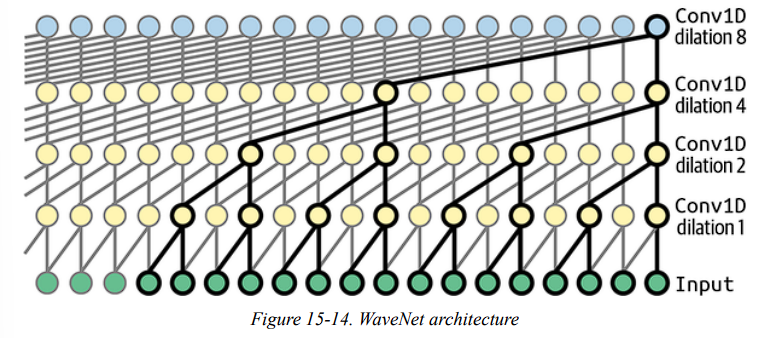

2. This way, the lower layers learn
short-term patterns, while the higher layers learn long-term patterns. Thanks
to the doubling dilation rate, the network can process extremely large
sequences very efficiently.

3. The authors of the paper actually stacked 10 convolutional layers with
dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of
10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then
again another identical group of 10 layers. They justified this architecture
by pointing out that a single stack of 10 convolutional layers with these
dilation rates will act like a super-efficient convolutional layer with a kernel
of size 1,024 (except way faster, more powerful, and using significantly
fewer parameters). They also left-padded the input sequences with a
number of zeros equal to the dilation rate before every layer, to preserve the
same sequence length throughout the network.

Here is how to implement a simplified WaveNet to tackle the same
sequences as earlier

In [81]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.Input(shape=[None,5]))
for rate in (1,2,4,8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32,kernel_size=2,padding="causal",
        activation="relu", dilation_rate = rate
    ))

wavenet_model.add(tf.keras.layers.Conv1D(filters=14,kernel_size=1))

In [82]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
     31/Unknown 3s 16ms/step - loss: 0.1341 - mae: 0.4506

C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1322 - mae: 0.4460 - val_loss: 0.0211 - val_mae: 0.1609
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0174 - mae: 0.1600 - val_loss: 0.0186 - val_mae: 0.1522
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0157 - mae: 0.1557 - val_loss: 0.0180 - val_mae: 0.1500
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0152 - mae: 0.1534 - val_loss: 0.0172 - val_mae: 0.1454
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0144 - mae: 0.1480 - val_loss: 0.0157 - val_mae: 0.1363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0157 - mae: 0.1363


136280.26843070984

the worse score is because covid time dataset. these models will only work well if the patterns they learned from the
past continue in the future

### Wavenet Implementation
Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:


In [83]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [84]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [85]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [86]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


C:\Users\haide\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_86']
Received: inputs=Tensor(shape=(None, None, 5))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1128 - mae: 0.3858 - val_loss: 0.0188 - val_mae: 0.1495
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0131 - mae: 0.1337 - val_loss: 0.0127 - val_mae: 0.1191
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0095 - mae: 0.1121 - val_loss: 0.0104 - val_mae: 0.1084
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0078 - mae: 0.0987 - val_loss: 0.0088 - val_mae: 0.0985
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0067 - mae: 0.0893 - val_loss: 0.0077 - val_mae: 0.0898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0077 - mae: 0.0898


89806.48219585419